In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import cv2
import random

import tensorflow as tf
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import add
from keras.layers import Activation
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import multiply
from keras.layers import concatenate

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split


In [2]:
path = "../input/lgg-mri-segmentation/kaggle_3m/"

In [3]:
df = pd.read_csv(path + "data.csv")
df.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

**Load images and masks**

In [5]:
# Separate images and masks in the directory
masks_dir = glob(path + "*/*_mask*")

images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))

In [6]:
# Create a new datafarme for brain images and masks
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()

file_images  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                          file_masks  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [7]:
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0

In [8]:
data_brain["mask"] = data_brain["file_masks"].apply(lambda x: positive_negative_diagnosis(x))

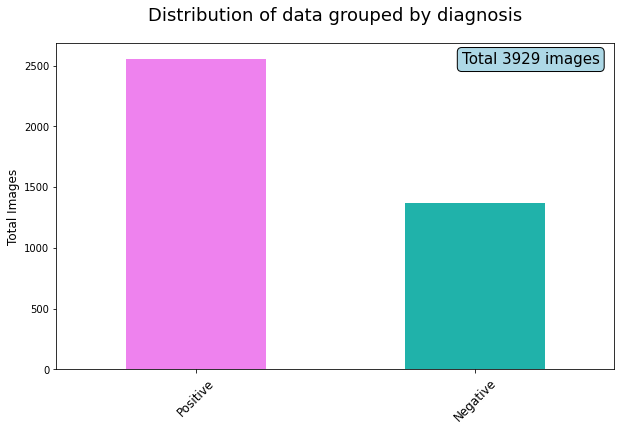

In [10]:
# Plot
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": images_dir,
                   "mask_path": masks_dir,
                  "diagnosis":[diagnosis(x) for x in masks_dir]})

ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [11]:
data_brain["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

**Data Visualization**

In [12]:
def show_image(df):

  fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(20, 40))
  count = 0
  i = 0
  for mask in df["mask"]:
    if mask == 1:
      # Show images
      image = io.imread(df.file_images[i])
      ax[count][0].title.set_text("Brain MRI")
      ax[count][0].imshow(image)

      # Show masks
      mask = io.imread(df.file_masks[i])
      ax[count][1].title.set_text("Mask Brain MRI")
      ax[count][1].imshow(mask, cmap="gray")

      # Show MRI Brain with mask
      image[mask == 255] = (0, 255, 0)    # Here, we want to modify the color of pixel at the position of mask
      ax[count][2].title.set_text("MRI Brain with mask")
      ax[count][2].imshow(image)
      count += 1
    i += 1
    if count == 10:
      break
  fig.tight_layout()
  plt.show()

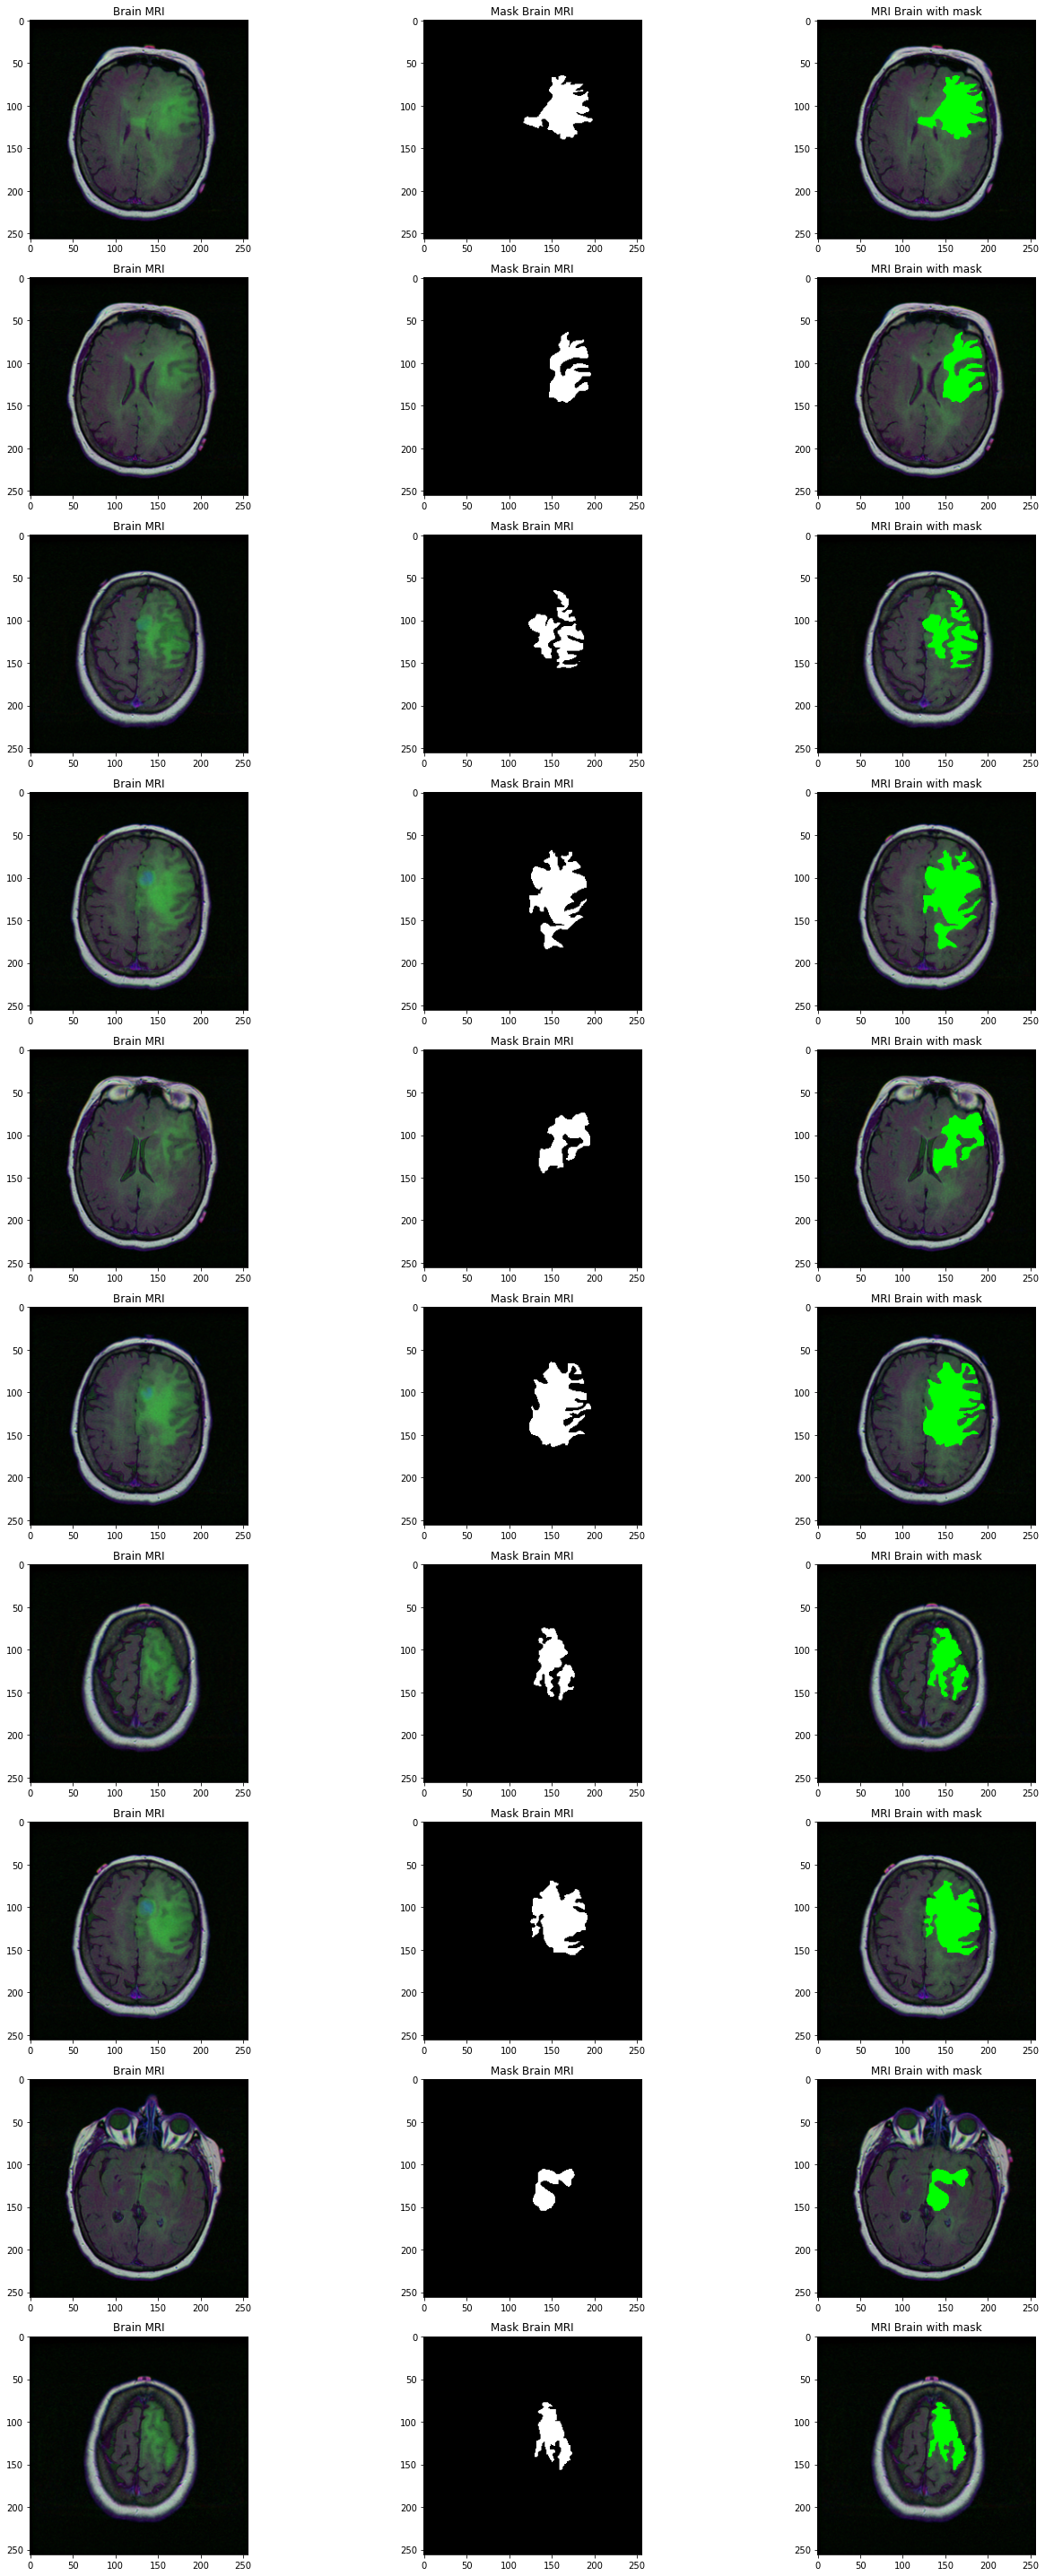

In [13]:
show_image(data_brain)

In [14]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

**Separate train, test, and val set**

In [15]:
# Load all images and masks
class ImageLoading():

  def __init__(self, img_path, mask_path):
    self.img_path = img_path
    self.mask_path = mask_path
    self.IMG_HEIGHT = 256
    self.IMG_WIDTH = 256
    # The number of classes for segmentation
    self.NUM_CLASSES = 1

    # Load images
    self.images_training = self.resize_images()
    print(self.images_training.shape)
    # Load masks
    self.masks_training = self.resize_masks()
    print(self.masks_training.shape)


  # resise the image
  def resize_images(self):
    images_training = []
    for imagePath in self.img_path:
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (self.IMG_WIDTH, self.IMG_HEIGHT))
      images_training.append(image)
    # Convert to numpy array
    images_training = np.array(images_training)
    return images_training

  # resise the mask
  def resize_masks(self):
    masks_training = []
    for maskPath in self.mask_path:
      mask = cv2.imread(maskPath, 0)
      mask = cv2.resize(mask, (self.IMG_WIDTH, self.IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
      masks_training.append(mask)
    # Convert to numpy array
    masks_training = np.array(masks_training)
    return masks_training


In [16]:
image_loader = ImageLoading(images_dir[:1000], masks_dir[:1000])
images_train = image_loader.resize_images()
masks_train = image_loader.resize_masks()

(1000, 256, 256, 3)
(1000, 256, 256)


In [17]:
# Normalize images
images_train = np.array(images_train) / 255.
masks_train = np.expand_dims((np.array(masks_train)), 3) /255.

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(images_train, masks_train, test_size=0.2, random_state=42)

print("X_train shape = {}".format(X_train.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("Y_test shape = {}".format(Y_test.shape))

X_train shape = (800, 256, 256, 3)
X_test shape = (200, 256, 256, 3)
Y_train shape = (800, 256, 256, 1)
Y_test shape = (200, 256, 256, 1)


In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
# Binary class
NUM_CLASS = 1
BATCH_SIZE = 32
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [21]:
# loss function and metrics
def dice_coef(y_pred, Y):
    y_flatten = K.flatten(Y)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_flatten * y_pred_flatten)
    dice = (0.2 * intersection + 1.0) / (K.sum(y_flatten) + K.sum(y_pred_flatten) + 1.0)
    return dice

def jacard_coef(y_pred, Y):
    y_flatten = K.flatten(Y)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_flatten * y_pred_flatten)
    jacard = (intersection + 1.0) / (K.sum(y_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return jacard

def jacard_coef_loss(y_pred, Y):
    return -jacard_coef(y_pred, Y)


def dice_coef_loss(y_pred, Y):
    return -dice_coef(y_pred, Y)


In [22]:
# Attention Unet
class Attention_UNet():
    def __init__(self, input_shape, num_classes=1, dropout=0, BatchNorm=True):
        super(Attention_UNet, self).__init__()
        self.max_pooling = True
        self.num_classes = num_classes
        self.input_shape = input_shape
        # number of basic filters for the first layer
        self.num_filters = 64
        # size of the convolutional filter
        self.filter_size = 3
        # size of upsampling filters
        self.upsampling_filter = 2


    def make_conv_block(self, input_layer, filter_size, num_filters, dropout=0, BatchNorm=False):
        conv_layer = Conv2D(num_filters, (filter_size, filter_size), padding="same")(input_layer)
        if BatchNorm is True:
            conv_layer = BatchNormalization(axis=3)(conv_layer)
        conv_layer = Activation("relu")(conv_layer)

        conv_layer = Conv2D(num_filters, (filter_size, filter_size), padding="same")(conv_layer)
        if BatchNorm is True:
            conv_layer = BatchNormalization(axis=3)(conv_layer)
        conv_layer = Activation("relu")(conv_layer)

        if dropout > 0:
            conv_layer = Dropout(dropout)(conv_layer)

        return conv_layer


    def make_repeat_elements(self, tensor, rep):
        """
           This function will repeat the elements of a tensor along an axis through a factor of rep using lambda function.
           For instance, if tensor has shape (None, 256,256,3), lambda will return a tensor of shape (None, 256,256,6),
           if specified axis=3 and rep=2
        """
        return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={"repnum":rep})(tensor)


    def _gate_signal(self, input_channels, output_channels, BatchNorm=False):
        """
            This function will resize the downsample layer feature map into the same dimension as the upsample
            layer feature map through 1x1 convolution

           return:
                the gating feature map with the same dimension of the up layer feature map
        """
        g = Conv2D(output_channels, (1,1), padding="same")(input_channels)
        if BatchNorm:
            g = BatchNormalization()(g)
        g = Activation("relu")(g)

        return g

    # We add attention block after shortcut connection in UNet
    def make_attention_block(self, input_layer, gating, num_filters):
        input_layer_shape = K.int_shape(input_layer)
        gating_shape = K.int_shape(gating)

        # Here, we should get the input_layer signal to the same shape as the gating signal
        input_layer_theta = Conv2D(num_filters, (2, 2), strides = (2, 2), padding = "same")(input_layer)
        input_layer_theta_shape = K.int_shape(input_layer_theta)

        # we should get the gating signal to the same number of filters as the num_filters
        gating_phi = Conv2D(num_filters, (1, 1), padding = "same")(gating)
        gating_upsample = Conv2DTranspose(num_filters,
                                          (3, 3),
                                          strides = (input_layer_theta_shape[1] // gating_shape[1],
                                                     input_layer_theta_shape[2] // gating_shape[2]),
                                          padding = "same")(gating_phi)
        concat_layer = add([gating_upsample, input_layer_theta])
        concat_layer = Activation("relu")(concat_layer)
        concat_layer = Conv2D(1, (1, 1), padding="same")(concat_layer)
        concat_layer = Activation("sigmoid")(concat_layer)   # To get weigth between 0 and 1
        concat_layer_shape = K.int_shape(concat_layer)
        concat_layer_upsampling = UpSampling2D(size = (input_layer_shape[1] // concat_layer_shape[1],
                                                       input_layer_shape[2] // concat_layer_shape[2]))(concat_layer)

        concat_layer_upsampling = self.make_repeat_elements(concat_layer_upsampling, input_layer_shape[3])

        y = multiply([concat_layer_upsampling, input_layer])

        # Final layer
        conv_result = Conv2D(input_layer_shape[3], (1, 1), padding="same")(y)
        conv_result_batchNorm = BatchNormalization()(conv_result)

        return conv_result_batchNorm

    def build_attention_unit(self, dropout=0, BatchNorm=True):
        input_layer = Input(self.input_shape, dtype=tf.float32)

        ############ Add downsampling layer ############
        # Block 1, 128
        encoder_128 = self.make_conv_block(input_layer, self.filter_size, self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        if self.max_pooling:
            encoder_pool_64 = MaxPooling2D(pool_size=(2, 2))(encoder_128)
        # Block 2, 64 layer
        encoder_64 = self.make_conv_block(encoder_pool_64, self.filter_size, 2 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        if self.max_pooling:
            encoder_pool_32 = MaxPooling2D(pool_size=(2, 2))(encoder_64)
        # Block 3, 32 layer
        encoder_32 = self.make_conv_block(encoder_pool_32, self.filter_size, 4 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        if self.max_pooling:
            encoder_pool_16 = MaxPooling2D(pool_size=(2, 2))(encoder_32)
        # Block 4, 8 layer
        encoder_16 = self.make_conv_block(encoder_pool_16, self.filter_size, 8 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        if self.max_pooling:
            encoder_pool_8 = MaxPooling2D(pool_size=(2, 2))(encoder_16)
        # Block 5, just convolutional block
        encoder_8 = self.make_conv_block(encoder_pool_8, self.filter_size, 16 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)

        ############ Upsampling layers #############
        # Block 6, attention gated concatenation + upsampling + double residual convolution
        gate_16 = self._gate_signal(encoder_8, 8 * self.num_filters, BatchNorm=BatchNorm)
        attention_block_16 = self.make_attention_block(encoder_16, gate_16, 8 * self.num_filters)
        decoder_16 = UpSampling2D(size=(self.upsampling_filter, self.upsampling_filter), data_format="channels_last")(
            encoder_8)
        decoder_16 = concatenate([decoder_16, attention_block_16], axis=3)
        decoder_conv_16 = self.make_conv_block(decoder_16, self.filter_size, 8 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        # Block 7
        gate_32 = self._gate_signal(decoder_conv_16, 4 * self.num_filters, BatchNorm=BatchNorm)
        attention_block_32 = self.make_attention_block(encoder_32, gate_32, 4 * self.num_filters)
        decoder_32 = UpSampling2D(size=(self.upsampling_filter, self.upsampling_filter), data_format="channels_last")(
            decoder_conv_16)
        decoder_32 = concatenate([decoder_32, attention_block_32], axis=3)
        decoder_conv_32 = self.make_conv_block(decoder_32, self.filter_size, 4 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        # Block 8
        gate_64 = self._gate_signal(decoder_conv_32, 2 * self.num_filters, BatchNorm=BatchNorm)
        attention_block_64 = self.make_attention_block(encoder_64, gate_64, 2 * self.num_filters)
        decoder_64 = UpSampling2D(size=(self.upsampling_filter, self.upsampling_filter), data_format="channels_last")(
            decoder_conv_32)
        decoder_64 = concatenate([decoder_64, attention_block_64], axis=3)
        decoder_conv_64 = self.make_conv_block(decoder_64, self.filter_size, 2 * self.num_filters, dropout=dropout, BatchNorm=BatchNorm)
        # Block 9
        gate_128 = self._gate_signal(decoder_conv_64, self.num_filters, BatchNorm=BatchNorm)
        attention_block_128 = self.make_attention_block(encoder_128, gate_128, self.num_filters)
        decoder_128 = UpSampling2D(size=(self.upsampling_filter, self.upsampling_filter), data_format="channels_last")(decoder_conv_64)
        decoder_128 = concatenate([decoder_128, attention_block_128], axis=3)
        decoder_conv_128 = self.make_conv_block(decoder_128, self.filter_size, self.num_filters, dropout=dropout, BatchNorm=BatchNorm)

        # Final convolutional layers (1 * 1)
        final_conv_lr = Conv2D(self.num_classes, kernel_size=1)(decoder_conv_128)
        final_conv_lr = BatchNormalization(axis=3)(final_conv_lr)
        # If a binary classification, we need to set "sigmoid" while for multichannel we should change to softmax
        final_conv_lr = Activation("sigmoid")(final_conv_lr)

        # Set the model
        model = Model(input_layer, final_conv_lr, name="Attention_UNet")
        print(model.summary())

        return model

In [23]:
unet_model = Attention_UNet(input_shape)

In [24]:
att_unet_model = unet_model.build_attention_unit()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [25]:
att_unet_model.compile(optimizer="adam", 
                       loss = "binary_crossentropy",
                       metrics=["binary_accuracy", iou, dice_coef])

In [26]:
history = att_unet_model.fit(X_train, Y_train, 
                             verbose=1,
                             batch_size = 8,
                             validation_data=(X_test, Y_test),
                             shuffle=False,
                             epochs=100)

Epoch 1/100
100/100 [==============================] - 54s 379ms/step - loss: 0.6994 - binary_accuracy: 0.6435 - iou: 0.0149 - dice_coef: 0.0029 - val_loss: 93.7716 - val_binary_accuracy: 0.0097 - val_iou: 0.0085 - val_dice_coef: 0.0016
Epoch 2/100
100/100 [==============================] - 36s 357ms/step - loss: 0.6281 - binary_accuracy: 0.9691 - iou: 0.0163 - dice_coef: 0.0031 - val_loss: 1.3032 - val_binary_accuracy: 0.0641 - val_iou: 0.0099 - val_dice_coef: 0.0019
Epoch 3/100
100/100 [==============================] - 36s 357ms/step - loss: 0.5868 - binary_accuracy: 0.9780 - iou: 0.0178 - dice_coef: 0.0034 - val_loss: 0.5403 - val_binary_accuracy: 0.9920 - val_iou: 0.0088 - val_dice_coef: 0.0016
Epoch 4/100
100/100 [==============================] - 36s 357ms/step - loss: 0.5459 - binary_accuracy: 0.9829 - iou: 0.0180 - dice_coef: 0.0034 - val_loss: 0.4809 - val_binary_accuracy: 0.9930 - val_iou: 0.0117 - val_dice_coef: 0.0022
Epoch 5/100
100/100 [==============================] - 

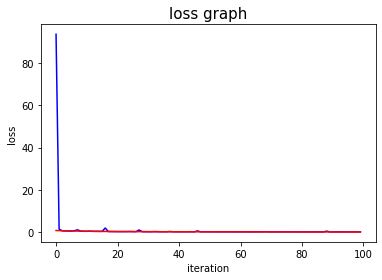

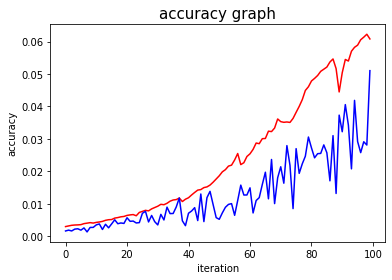

In [32]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


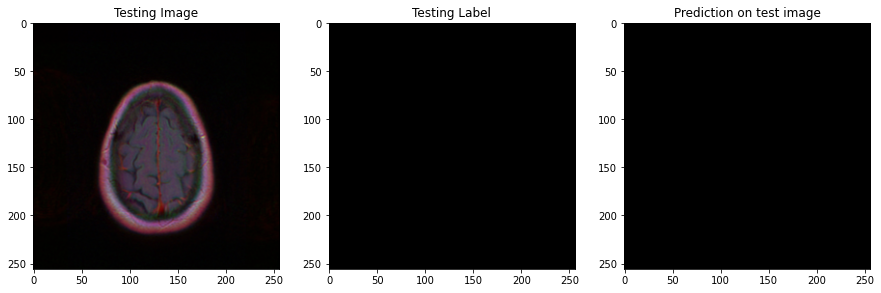

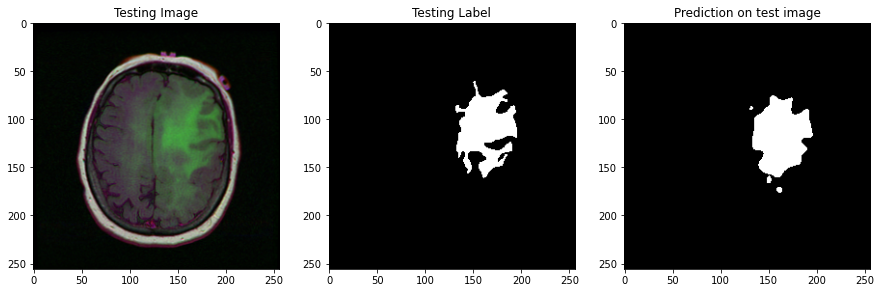

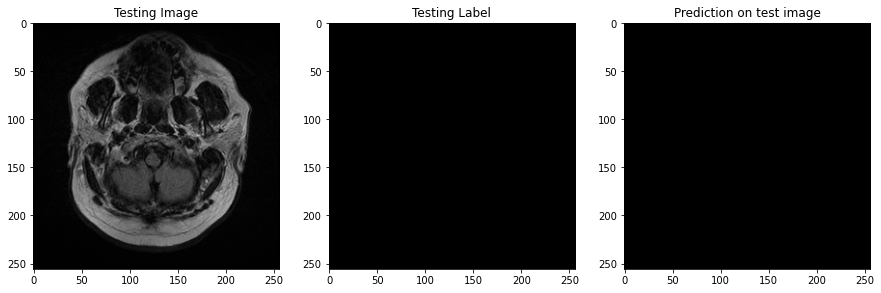

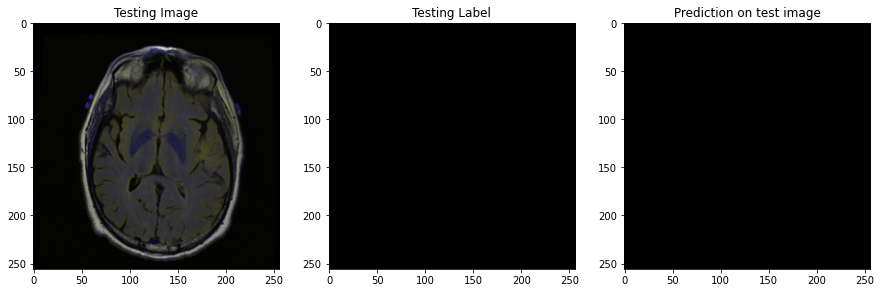

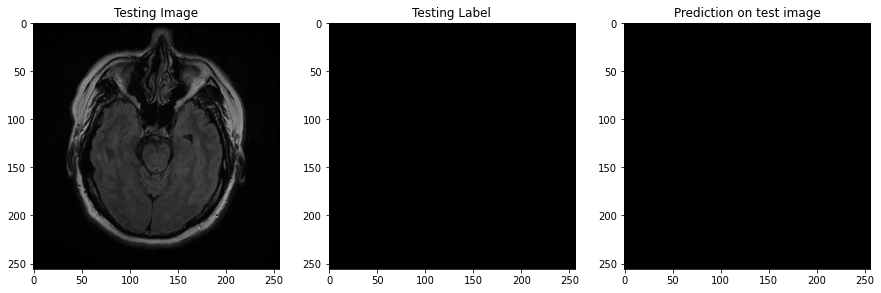

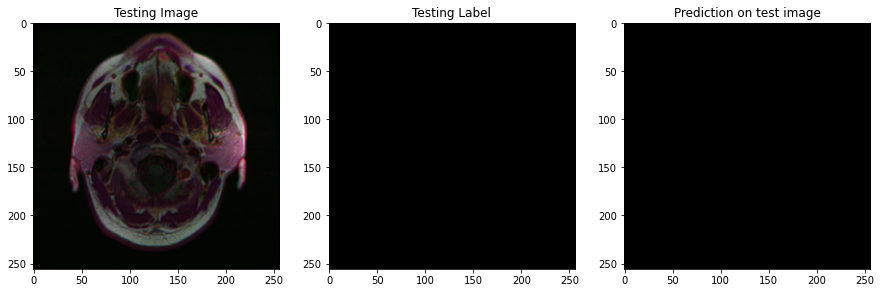

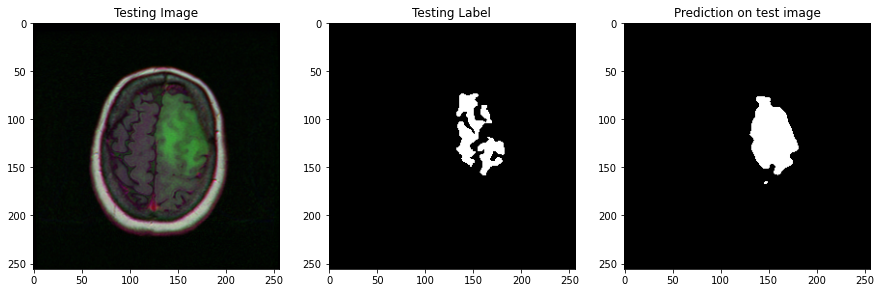

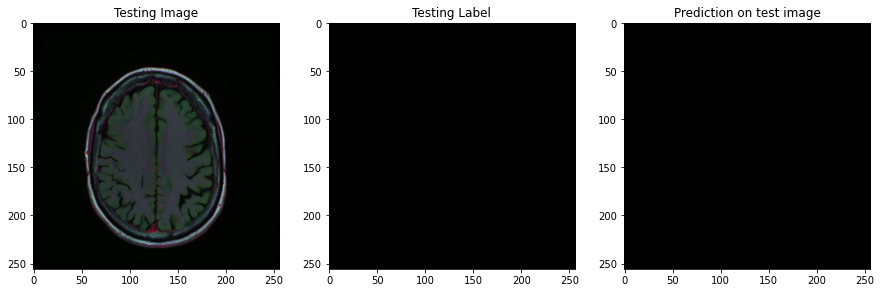

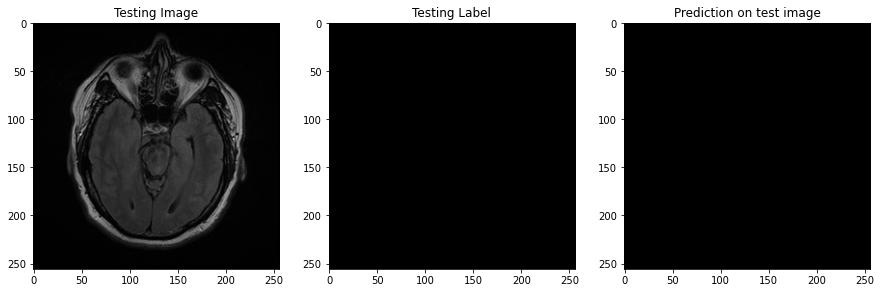

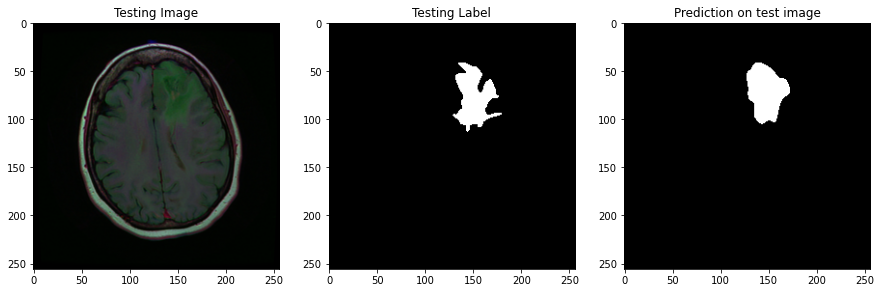

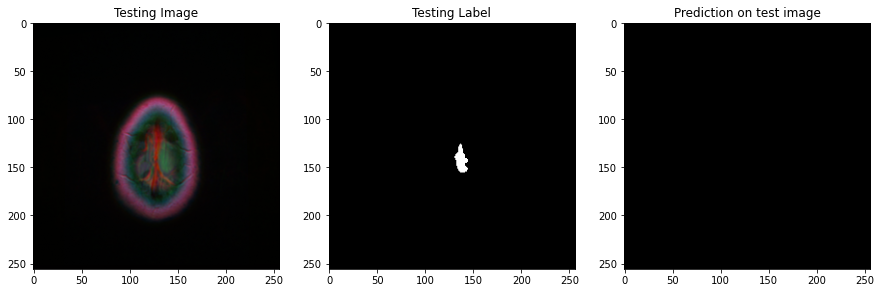

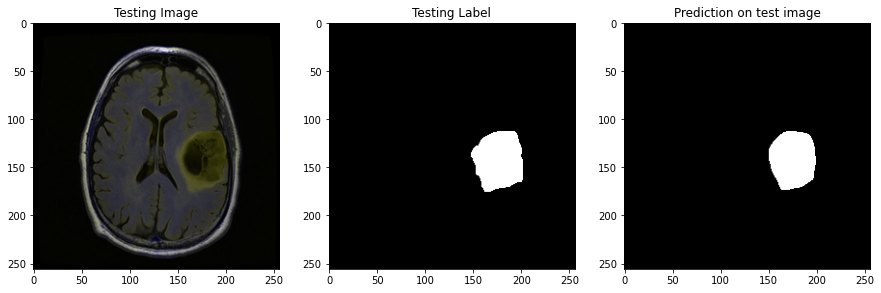

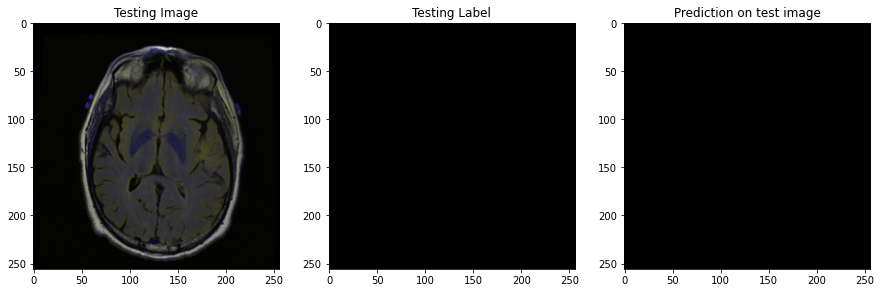

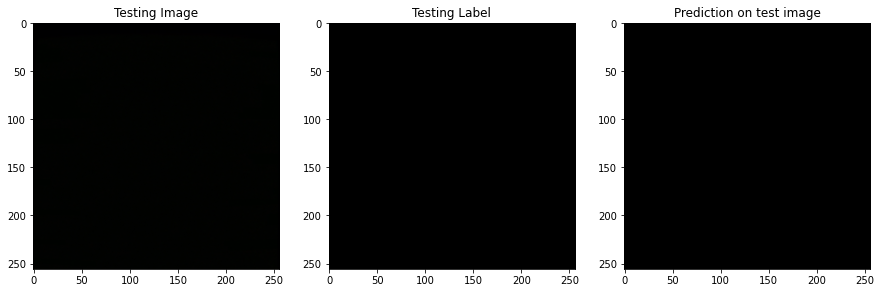

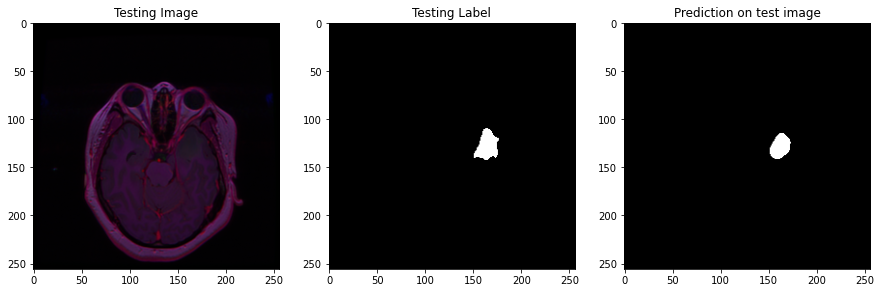

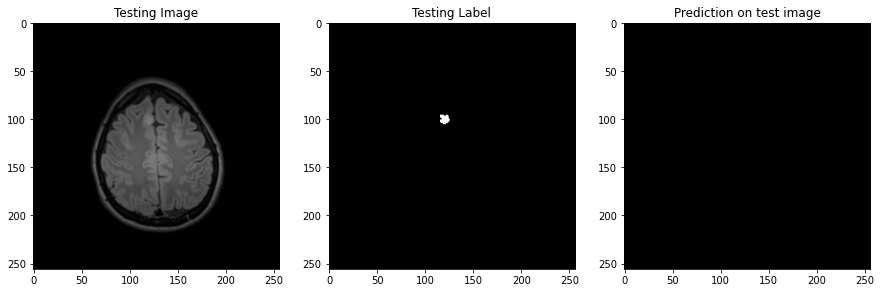

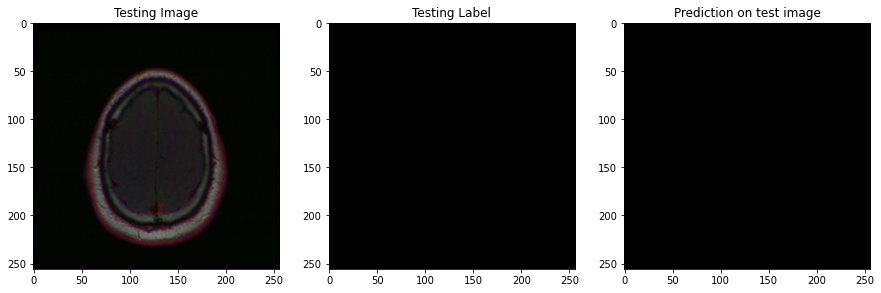

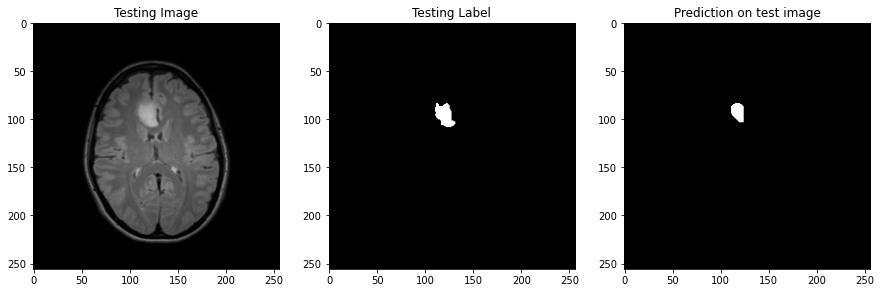

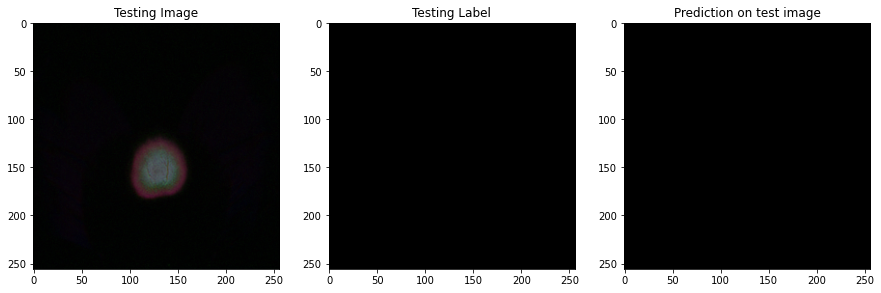

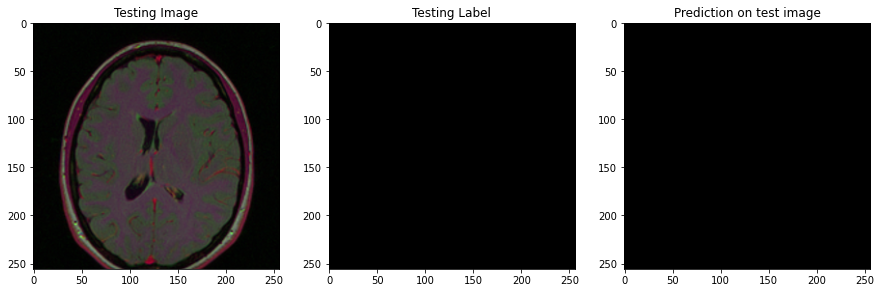

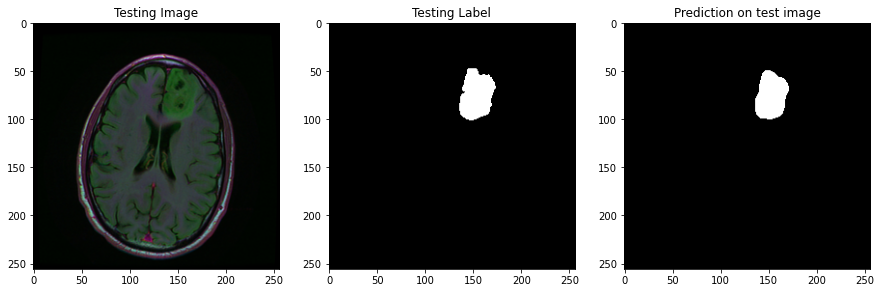

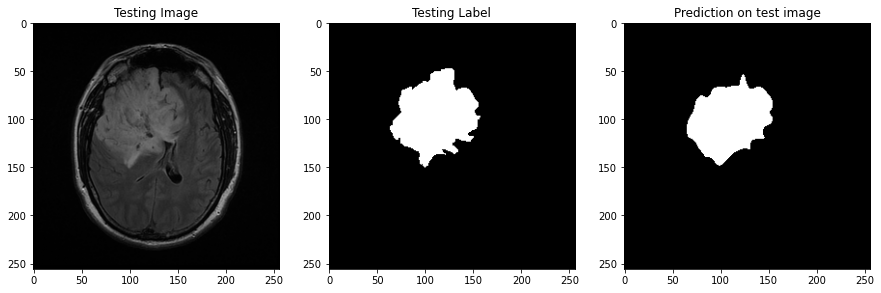

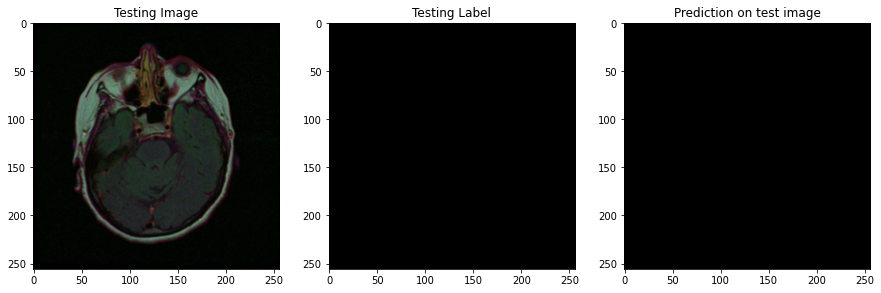

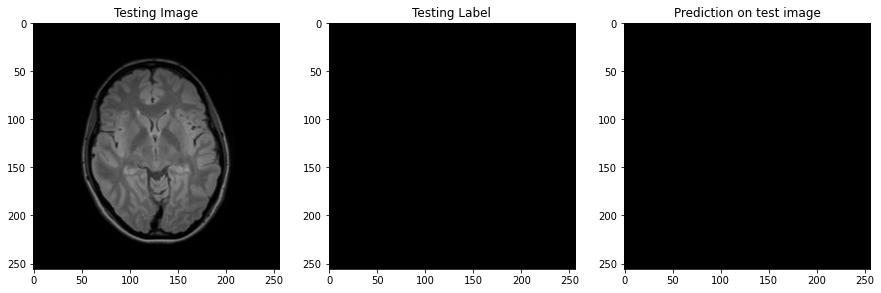

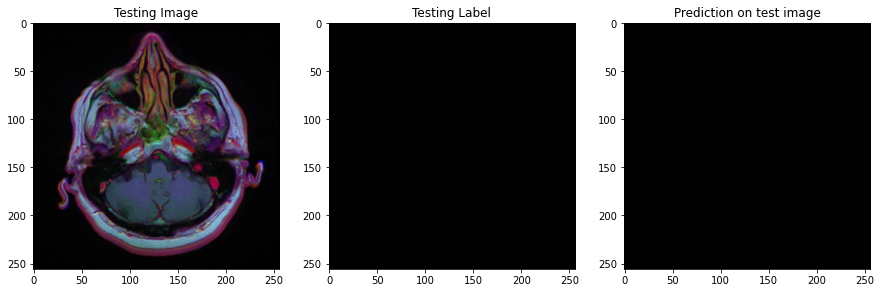

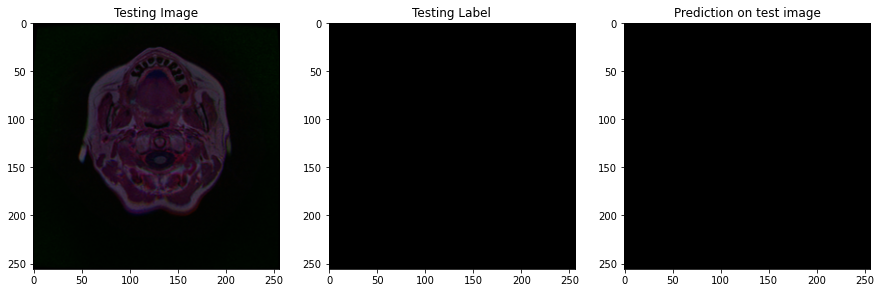

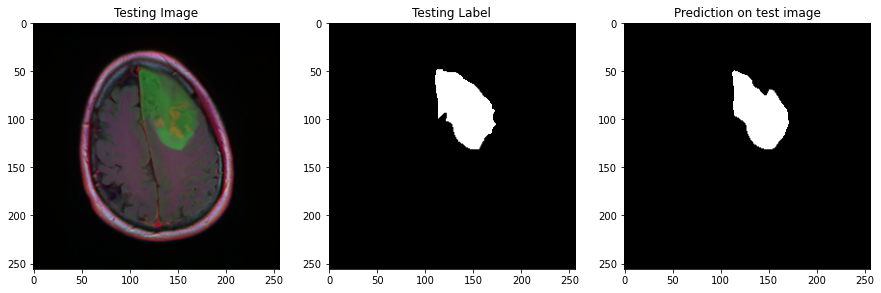

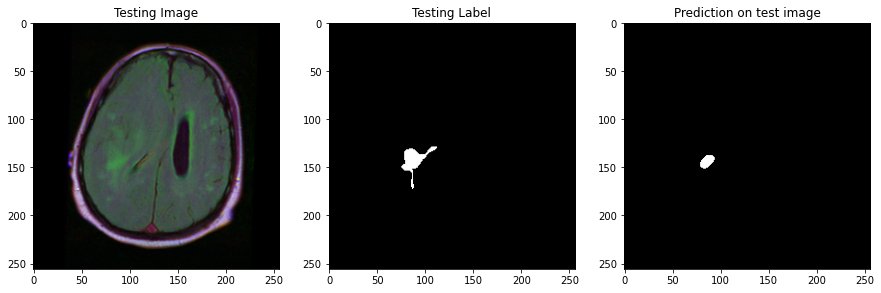

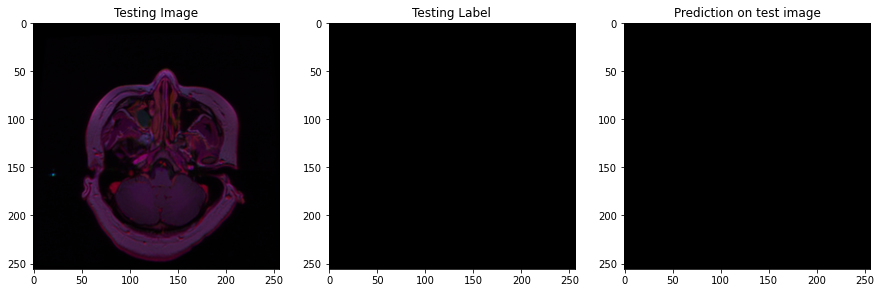

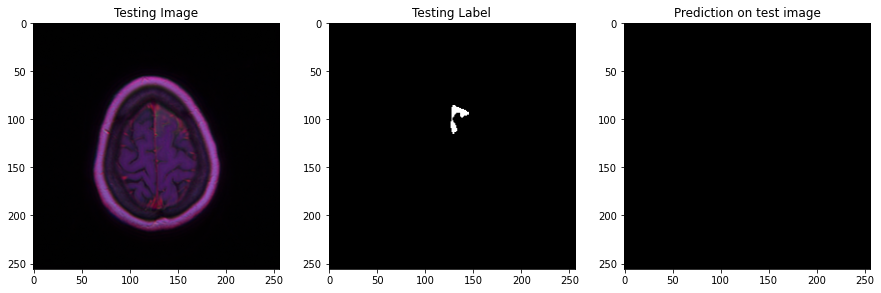

In [40]:
for i in range(30):
    num_img_test = random.randint(0, X_test.shape[0]-1)
    img_test = X_test[num_img_test]
    test_label = Y_test[num_img_test]

    img_test_input = np.expand_dims(img_test, 0)
    pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)

    # Visualize the result 
    plt.figure(figsize=(15, 10))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(img_test, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_label[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(pred, cmap='gray')
    